## Monte carlo the models

In [189]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from tools import plot_confusion_matrix
from getSIDMdata_generator_meta import get_tf_DataSet as getGenerators
from tqdm import tqdm
import pickle as pkl
from scipy.stats import norm
import sys
import mertens_models as mertens
from matplotlib.gridspec import GridSpec
import scienceplots
from tools import get_best_model,get_predictions_per_subset
plt.style.use(["science", "grid"])

In [194]:
#Numbers that define how long this script takes -
epochs = 80 # Epochs for each model to train
monte_carlo = 20 # Number of shuffles of the training / test set and retrains

In [215]:
nDM_Models = 5 #Number of classifications in the model
if os.path.isfile("pickles/final_model.pkl"):
    all_probs, prob_sidm0_3, monte_carlo_histories = pkl.load(open("pickles/final_model.pkl","rb"))
 

#### Train many models with differeing random states to get variance in model.

In [222]:
all_probs, prob_sidm0_3, monte_carlo_histories = pkl.load(open("pickles/final_inception_model.pkl","rb"))

In [ ]:
model_name = 'inception'
monte_carlo_tests = [] #A record of the test sets used
monte_carlo_histories = [] #A record of the histories of the modelling
all_probs = [] #A record of the probabilities predicted for the test set
prob_sidm0_3 = [] # A record of the probabilities predicted for SIDM 0.3 test set
simulationNames = ['CDM','SIDM0.1','SIDM1']
nDM_Models = len(simulationNames)

for i in tqdm(range(monte_carlo)):
    train, test = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=i)
   
    checkpoint_filepath = 'models/%s/%i' % (model_name, i)
  
    model = get_best_model( train, test, model_name=model_name, checkpoint_filepath=checkpoint_filepath, epochs=epochs)
    
    monte_carlo_tests.append( test )
    monte_carlo_histories.append( model.history.history )
    
    iDM_model_probs = [] 
    for iDM_model in range(nDM_Models):
        this_dm_model_test_feat = test[0][ test[1] == iDM_model ]
        this_dm_model_test_labels = test[1][ test[1] == iDM_model ]

        
        iDM_model_probs.append(model.predict( this_dm_model_test_feat, verbose=0 ))
    all_probs.append(iDM_model_probs)
    
    train, test = getGenerators(augment_data=True, simulationNames=['SIDM0.3'], train_split=0.01, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=i)
    
    prob_sidm0_3.append(model.predict( test[0], verbose=0 ))
    
all_probs = np.array(all_probs)
prob_sidm0_3 = np.array(prob_sidm0_3)

pkl.dump([all_probs, prob_sidm0_3, monte_carlo_histories], open("pickles/final_model_%s.pkl" % model_name,"wb"))

In [197]:
#all_probs = np.array(all_probs)
#prob_sidm0_3 = np.array(prob_sidm0_3)

pkl.dump([all_probs, prob_sidm0_3, monte_carlo_histories], open("pickles/final_model_%s_again.pkl" % model_name,"wb"))

#### Now see the distribution of probabilities for cluster for each model - not really fair since i trian on these and they are far apart.

0.0004646449683090516 0.0019426901519714506
0.09354155663171616 0.004816142992836955
0.9999999999974882 4.168007983389203e-07


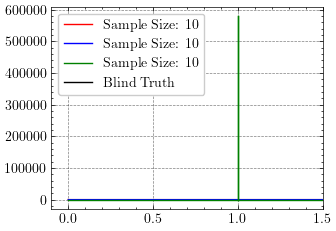

In [83]:
c = ['r','b','g','c','purple']

nDM_Models = all_probs.shape[1]
  
n_samples_per_subset = 10  
ax = plt.gca()

stds = []
for iDM_model in range(nDM_Models):
       
    these_probs = np.exp(all_probs[:,iDM_model,:,:])
    these_probs = these_probs/np.sum(these_probs,axis=-1)[:,:,np.newaxis]  

    prediction = get_predictions_per_subset( these_probs, n_samples_per_subset,  cross_sections=[0.0,0.1,1.0])

    #ax.hist(prediction, color=c[iTelescope], alpha=0.5, density=True, bins=np.linspace(0.,0.5,10))
    
    mean = np.median(prediction)
    std = np.std(prediction)
    print(mean,std)
    stds.append(std)
    x = np.logspace(-5,0.5,1000)
    pdf = norm.pdf(x, mean, std)
    ax.plot(x, pdf, color=c[iDM_model])
    

    #ax.plot([mean-std,mean-std],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    #ax.plot([mean,mean],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    #ax.plot([mean+std,mean+std],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    ax.fill_between( x[ (x > mean-std) & (x < mean+std) ], 
                    np.zeros(len(x[ (x > mean-std) & (x < mean+std) ])),
                    pdf[ (x > mean-std) & (x < mean+std) ], color=c[iDM_model], alpha=0.1)
    ax.plot( [mean-std,mean-std],[0,norm.pdf(mean-std, mean, std)], '-',color=c[iDM_model], label='Sample Size: %i' % n_samples_per_subset )
    ax.plot( [mean+std,mean+std],[0,norm.pdf(mean+std, mean, std)], '-',color=c[iDM_model])

ax.set_xlim(-0.1,1.5)
#ax.set_xticks(np.linspace(0,0.5,6))
#ax.set_xscale('log')
ax.plot([0.3,0.3],[0,12],'k-',label='Blind Truth')
ax.legend(loc=2)
plt.savefig("../plots/dm_models_blind_test.pdf")

#### Now look at how well it does at guessing SIDM0.3!

In [217]:
these_probs.shape

(20, 1188, 5)

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/sidm_0p3_blind_test.pdf'.


0

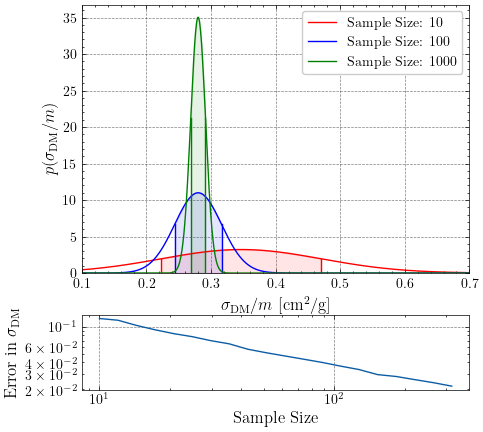

In [230]:
plt.figure(figsize=(5,5))
gs = GridSpec(20,1)

ax = plt.subplot(gs[:14,0])
c = ['r','b','g','c']
stds = []
cross_sections = np.array([0.,0.1,1.0])
for iTelescope, n_samples_per_subset in enumerate([ 10, 100, 1000]):
   
    these_probs = np.exp(prob_sidm0_3)
    these_probs = these_probs/np.sum(these_probs,axis=-1)[:,:,np.newaxis]


    prediction,err = get_predictions_per_subset( these_probs, n_samples_per_subset,  
                                                cross_sections=cross_sections)

    #ax.hist(prediction, color=c[iTelescope], alpha=0.5, density=True, bins=np.linspace(0.,0.5,10))
    
    mean = np.nanmedian(prediction)
    std =  np.nanmean(err) #np.std(prediction)/np.sqrt(n_samples_per_subset)
    stds.append(std)

    x = np.linspace(0.,0.7,1000)
    pdf = norm.pdf(x, mean, std)
    ax.plot(x, pdf, color=c[iTelescope])
    
    if iTelescope == 0:
        ylims = ax.get_ylim()
    #ax.plot([mean-std,mean-std],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    #ax.plot([mean,mean],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    #ax.plot([mean+std,mean+std],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    ax.fill_between( x[ (x > mean-std) & (x < mean+std) ], 
                   np.zeros(len(x[ (x > mean-std) & (x < mean+std) ])),
                    pdf[ (x > mean-std) & (x < mean+std) ], color=c[iTelescope], alpha=0.1)
    ax.plot( [mean-std,mean-std],[0,norm.pdf(mean-std, mean, std)], '-',color=c[iTelescope], label='Sample Size: %i' % n_samples_per_subset )
    ax.plot( [mean+std,mean+std],[0,norm.pdf(mean+std, mean, std)], '-',color=c[iTelescope])
subsets = np.logspace(1,2.5,20)
stds = [ np.nanmean(  get_predictions_per_subset( these_probs, int(i),  cross_sections=cross_sections)[1]) for i in subsets ]
ax1 = plt.subplot(gs[16:,0])
ax1.set_yscale('log')

ax1.plot(subsets, stds)

ax1.set_xlabel('Sample Size',fontsize=12)
ax1.set_ylabel('Error in $\sigma_{\\rm DM}$',fontsize=12)
ax1.set_xscale('log')


ax.set_ylim(0,ax.get_ylim()[1])
ax.set_xlim(0.1,0.7)

#ax.set_xticks(np.linspace(0,0.5,6))
#ax.set_xscale('log')
#ax.plot([0.3,0.3],[0,12],'k-',label='Blind Truth')
ax.legend(loc=1)
ax.set_ylim(0,ax.get_ylim()[1])
ax.set_xlabel(r'$\sigma_{\rm DM}/m$ [cm$^2$/g]',fontsize=12)
ax.set_ylabel(r'$p(\sigma_{\rm DM}/m)$',fontsize=12)
filename = "../plots/sidm_0p3_blind_test.pdf"
plt.savefig(filename)
os.system("pdfcrop %s %s" % (filename, filename))

### Now I am doing the same but asking what happens if i dont train on CDM_hi and it is CDM_hi

In [160]:
all_probs, prob_test, monte_carlo_histories = pkl.load( open("pickles/final_inception_model_wrong_baryons.pkl","rb"))

In [ ]:
model_name = 'inception'
monte_carlo_tests = [] #A record of the test sets used
monte_carlo_histories = [] #A record of the histories of the modelling
all_probs = [] #A record of the probabilities predicted for the test set
prob_test = [] # A record of the probabilities predicted for SIDM 0.3 test set
simulationNames = ['CDM_low','CDM','SIDM0.1','SIDM1']
test_name = 'CDM_hi'
nDM_Models = len(simulationNames)

for i in tqdm(range(monte_carlo)):
    train, test = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=i)
   
    checkpoint_filepath = 'models/%s_wrong_baryons/%i' % (model_name, i)
  
    model = get_best_model( train, test, model_name=model_name, checkpoint_filepath=checkpoint_filepath)
    
    monte_carlo_tests.append( test )
    monte_carlo_histories.append( model.history.history )
    
    iDM_model_probs = [] 
    for iDM_model in range(nDM_Models):
        this_dm_model_test_feat = test[0][ test[1] == iDM_model ]
        this_dm_model_test_labels = test[1][ test[1] == iDM_model ]

        
        iDM_model_probs.append(model.predict( this_dm_model_test_feat, verbose=0 ))
        
    all_probs.append(iDM_model_probs)
    
    train, test = getGenerators(augment_data=True, simulationNames=[test_name], train_split=0.01, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=i)
    
    prob_test.append(model.predict( test[0], verbose=0 ))
    
all_probs = np.array(all_probs)
prob_test = np.array(prob_test)

pkl.dump([all_probs, prob_test, monte_carlo_histories], open("pickles/final_inception_model_wrong_baryons.pkl","wb"))

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/dm_models_dm_wrong.pdf'.


0

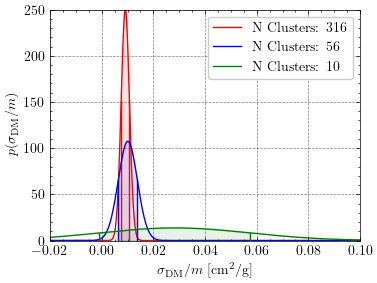

In [238]:
c = ['r','b','g','c','purple']
plt.figure(figsize=(4,3))
ax = plt.gca()

for i, iSubSample in enumerate(np.logspace(1,2.5,3)[::-1]):
    
    these_probs = np.exp(prob_test)
    these_probs = these_probs/np.sum(these_probs,axis=-1)[:,:,np.newaxis]

    prediction, err = get_predictions_per_subset( these_probs, int(iSubSample), cross_sections=[0,0.,0.1,1.0], return_weights=False)

    
    mean = np.nanmedian(prediction)
    std = np.nanmean(err)#/np.sqrt(len(prediction))
    x = np.linspace(-0.1,0.5,10000)
    pdf = norm.pdf(x, mean, std)
    ax.plot(x, pdf, color=c[i])
    if i == 0:
        ylims = ax.get_ylim()
    #ax.plot([mean-std,mean-std],[0,ylims[1]*1.1],'--', color=c[i])
    #ax.plot([mean,mean],[0,ylims[1]*1.1],'--', color=c[i])
    #ax.plot([mean+std,mean+std],[0,ylims[1]*1.1],'--', color=c[i])
    ax.fill_between( x[ (x > mean-std) & (x < mean+std) ], 
                    np.zeros(len(x[ (x > mean-std) & (x < mean+std) ])),
                    pdf[ (x > mean-std) & (x < mean+std) ], color=c[i], alpha=0.1)
    ax.plot( [mean-std,mean-std],[0,norm.pdf(mean-std, mean, std)], '-',color=c[i], label="N Clusters: %i" % iSubSample )
    ax.plot( [mean+std,mean+std],[0,norm.pdf(mean+std, mean, std)], '-',color=c[i])

#ax.set_ylim(0,12)
ax.set_xlim(-0.02,0.1)
#ax.set_xscale('log')
ylim = ax.get_ylim()
#ax.plot([0.1,0.1],[0,ylim[1]*1.1],'k-',label='Blind Truth')
#ax.plot([1,1],[0,ylim[1]*1.1],'k-',label='Blind Truth')
ax.set_ylim(0,250)
ax.legend(loc=1)
ax.set_xlabel(r'$\sigma_{\rm DM}/m$ [cm$^2$/g]')
ax.set_ylabel(r'$p(\sigma_{\rm DM}/m)$')
filename="../plots/dm_models_dm_wrong.pdf"
plt.savefig(filename)
os.system("pdfcrop %s %s" % (filename, filename))

### Variance in the accuracy

In [ ]:
simulationNames = ['CDM','SIDM0.1','SIDM1']


In [ ]:
all_probs.shape

In [ ]:
preds = [] 
m = tf.keras.metrics.Accuracy()
m.result().numpy()
nDM_Models = all_probs.shape[1]
for iM in range(all_probs.shape[0]):
    train, test = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=iM)
    iPreds = np.array([])
    
    for iDM_model in range(nDM_Models):
        this_dm_model_test_feat = test[0][ test[1] == iDM_model ]
        this_dm_model_test_labels = test[1][ test[1] == iDM_model ]


        predictions = np.argmax( all_probs[iM, iDM_model,:,:], axis=1)
        m.update_state( predictions, this_dm_model_test_labels )
    
        iPreds = np.append(iPreds, m.result().numpy())
    
    preds.append( iPreds)

                

In [ ]:
m